In [ ]:
!pip install datasets
!pip install transformers
!pip install sentencepiece
!pip install easynmt
!pip install nlpaug

     |████████████████████████████████| 290 kB 5.3 MB/s 
     |████████████████████████████████| 243 kB 36.2 MB/s 
     |████████████████████████████████| 1.3 MB 36.8 MB/s 
     |████████████████████████████████| 56 kB 4.4 MB/s 
     |████████████████████████████████| 125 kB 47.8 MB/s 
     |████████████████████████████████| 160 kB 48.0 MB/s 
     |████████████████████████████████| 271 kB 46.5 MB/s 
     |████████████████████████████████| 2.9 MB 5.3 MB/s 
     |████████████████████████████████| 596 kB 41.0 MB/s 
     |████████████████████████████████| 895 kB 43.5 MB/s 
     |████████████████████████████████| 3.3 MB 48.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 5.2 MB/s 
     |████████████████████████████████| 68 kB 3.5 MB/s 
  Using cached pybind11-2.8.0-py2.py3-none-any.whl (207 kB)
  Created wheel for easynmt: filename=EasyNM

In [ ]:
i = [1000, 20]
[i[a] for a in [0,1]]

[1000, 20]

In [ ]:
scores = [0.99, 0.5, 0.01]
threshold = 0.3
[i for i,v in enumerate(scores) if v > threshold]

[0, 1]

In [ ]:
import pandas as pd
import numpy as np
import pickle
import torch

In [ ]:
# Translator class

from transformers import M2M100ForConditionalGeneration, M2M100Tokenizer
from easynmt import EasyNMT

# base class
class Translator:
  def __init__(self, src, tgt):
    self.src = src
    self.tgt = tgt
  
  def _translate(self, text, src, tgt):
    pass

  def forward(self, text):
    return self._translate(text, src=self.src, tgt=self.tgt)

  def backward(self, text):
    return self._translate(text, src=self.tgt, tgt=self.src)
  
  def back_translate(self, text, src_lang):
    if src_lang == self.src:
      forward_translated = self.forward(text)
      backward_translated = self.backward(forward_translated)
      return backward_translated
    
    elif src_lang == self.tgt:
      forward_translated = self.backward(text)
      backward_translated = self.forward(forward_translated)
      return backward_translated
    
    else:
      raise Exception(f"Source language must be one of {self.src} or {self.tgt}")


class M2MTranslator(Translator):
  def __init__(self, src, tgt, model="facebook/m2m100_418M"):
    super().__init__(self, src, tgt)
    self.tokenizer = M2M100Tokenizer.from_pretrained(model)
    self.model = M2M100ForConditionalGeneration.from_pretrained(model)

  def _translate(self, text, src, tgt):
    self.tokenizer.src_lang = src
    # Force the decoder's start token to be the target lang
    decoder_start_token_id = self.tokenizer.get_lang_id(tgt)
    encoded_text = self.tokenizer(text, return_tensors="pt")
    generated_tokens = self.model.generate(**encoded_text, forced_bos_token_id=decoder_start_token_id)
    translated_text = self.tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
    return translated_text

class OpusTranslator(Translator):
  def __init__(self, src, tgt):
    super().__init__(src, tgt)
    self.model = EasyNMT('opus-mt')

  def _translate(self, text, src, tgt):
    return self.model.translate(text, source_lang=src, target_lang=tgt)


# Data preparation

Read in data  
Remove topics which have lower than 50 examples

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/fine-tuning/2021-01-01_to_2021-01-07.csv")
df = df.drop(columns="Unnamed: 0")
vc = df['topic'].value_counts()
topics_less_than_50 = vc[vc < 50].index
df = df[~df['topic'].isin(topics_less_than_50)]

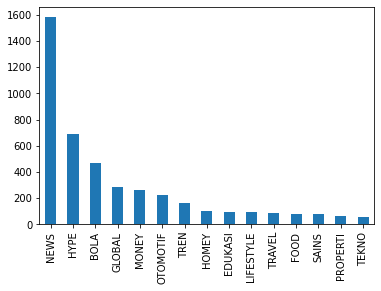

In [ ]:
df['topic'].value_counts().plot.bar()

Dataset labels are unbalanced - need to apply stratified splitting when separating train, test, validation sets

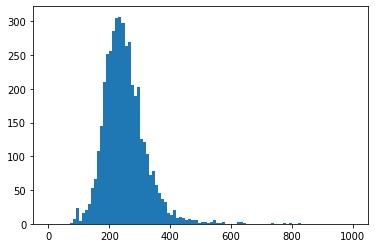

In [ ]:
(df['text'].str.split().apply(len).hist(bins=np.linspace(0,1000,101), grid=False));

Note: Most articles are between 180 - 400 words long.

## Stratify Split dataset into following proportions   
10% train   
10% validation   
10% test  
70% unsupervised

In [ ]:
from sklearn.model_selection import train_test_split
np.random.seed(31415)

indices = np.expand_dims(np.arange(len(df)), axis=1)
labels = np.array(list(df['topic']))
label_map = {label: i for i, label in enumerate(set(labels))}

X_unsup, X_rem, y_unsup, y_rem = train_test_split(indices, labels, stratify=labels, test_size=0.33333333)
X_train, X_valid_test, y_train, y_valid_test = train_test_split(X_rem, y_rem, stratify=y_rem, test_size=0.6666666)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid_test, y_valid_test, stratify=y_valid_test, test_size=0.5)

print(f"X_unsup shape: {X_unsup.shape}")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"X_valid shape: {X_valid.shape}")

def get_rows_from_index_and_drop_cols(df, ind):
  return df.iloc[np.squeeze(ind, axis=1)][['text', 'topic']]

unsup = get_rows_from_index_and_drop_cols(df, X_unsup)
train = get_rows_from_index_and_drop_cols(df, X_train)
test = get_rows_from_index_and_drop_cols(df, X_test)
valid = get_rows_from_index_and_drop_cols(df, X_valid)

from datasets import Dataset, DatasetDict

ds = DatasetDict({
    "train": Dataset.from_pandas(train.reset_index(drop=True)),
    "valid": Dataset.from_pandas(valid.reset_index(drop=True)),
    "test": Dataset.from_pandas(test.reset_index(drop=True)),
    "unsup": Dataset.from_pandas(unsup.reset_index(drop=True))
})

X_unsup shape: (2884, 1)
X_train shape: (480, 1)
X_test shape: (481, 1)
X_valid shape: (481, 1)


Split the training data into different training slices of [16, 32, 64, 128, 256, len(training_data)]  
This will be used to estimate how model accuracy scales with the increase in training data size

In [ ]:
all_indices = np.expand_dims(list(range(len(ds['train']))), axis=1)
indices_pool = all_indices
labels = ds['train']['topic']
train_samples = [16, 32, 64, 128, 256]
train_slices, last_k = [], 0

for i, k in enumerate(train_samples):
  # split off samples necessary to fill the gap to the next split size
  indices_pool, new_slice, labels, _ = train_test_split(indices_pool, labels, test_size=(k-last_k)/len(labels), stratify=labels)
  last_k = k
  if i == 0:
    train_slices.append(new_slice)
  else: 
    train_slices.append(np.concatenate((train_slices[-1], new_slice)))

# add full dataset as last slice
train_slices.append(all_indices), train_samples.append(len(ds["train"]))
train_slices = [np.squeeze(train_slice) for train_slice in train_slices]
print(f"Train slice sizes: {[len(slice) for slice in train_slices]}")

def prepare_labels(row):
  row['label_ids'] = label_map[row['topic']]
  return row

ds = ds.map(prepare_labels)

all_labels = list(label_map.keys())

Train slice sizes: [16, 32, 64, 128, 256, 480]


  0%|          | 0/480 [00:00<?, ?ex/s]

  0%|          | 0/481 [00:00<?, ?ex/s]

  0%|          | 0/481 [00:00<?, ?ex/s]

  0%|          | 0/2884 [00:00<?, ?ex/s]

# Data modelling
Explore various methods to check how well they can perform on limited training data  
We will store the results of the different models into the macro_scores dictionary  

In [ ]:
from collections import defaultdict
# We will use macro f1 score as our metric
macro_scores = defaultdict(list)

### Naive Bayes w/ CountVectorizer model
This will be our baseline model

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer

for train_slice in train_slices:
  ds_train_sample = ds['train'].select(train_slice)
  y_train = np.array(ds_train_sample['label_ids'])
  y_valid = np.array(ds['valid']['label_ids'])

  vect = CountVectorizer()
  X_train = vect.fit_transform(ds_train_sample['text'])
  X_valid = vect.transform(ds['valid']['text'])

  classifier = MultinomialNB()
  classifier.fit(X_train, y_train)

  y_pred = classifier.predict(X_valid)
  clf_report = classification_report(y_valid, y_pred, output_dict=True, zero_division=0)
  macro_scores['Naive Bayes'].append(clf_report['macro avg']['f1-score'])

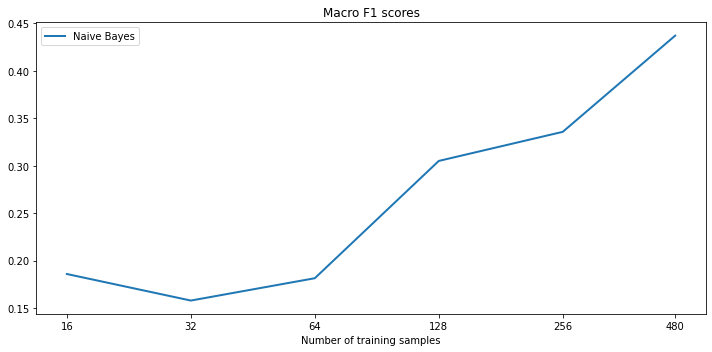

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(macro_scores, sample_sizes, current_model):
    fig, ax0 = plt.subplots(1, 1, figsize=(10, 5), sharey=True)

    for run in macro_scores.keys():
        if run == current_model:
            ax0.plot(sample_sizes, macro_scores[run], label=run, linewidth=2)
        else:
            ax0.plot(sample_sizes, macro_scores[run], label=run,
                     linestyle="dashed")

    ax0.set_title("Macro F1 scores")
    ax0.set_xlabel("Number of training samples")
    ax0.legend(loc="upper left")
    ax0.set_xscale("log")
    ax0.set_xticks(sample_sizes)
    ax0.set_xticklabels(sample_sizes)
    ax0.minorticks_off()
    plt.tight_layout()

plot_metrics(macro_scores, train_samples, "Naive Bayes")

Our baseline Naive Bayes model achieves a macro f1 score of about 43%

### Zero shot classification
References: https://discuss.huggingface.co/t/new-pipeline-for-zero-shot-text-classification/681  
Read the reference above for a better understanding of zero-shot classification.  
The main idea behind zero-shot classification is to make use of the Natural Language Inference task to predict if the sentence belongs to the label.   
In NLI, two sentences (premise and hypothesis) are fed into the model and the output would be one of [contradiction, entailment or neutral]. In zero-shot classification, the first sentence (premise) would be the text to be predicted and the second sentence would be "This example is {label}"(hypothesis). The output would then be the logits for the entailment vs contradiction label in NLI which is fed through a softmax layer.


Model choice: We will use the default model (facebook/bart-large-mnli).     
This model takes a long time to run but the accuracy of the model drastically outperforms other smaller models by a large margin

In [ ]:
from transformers import pipeline

pipe = pipeline("zero-shot-classification", device=0)

sample = ds["train"][0]
print("label:", sample["topic"])
output = pipe(sample["text"], all_labels, multi_label=True)
print(output["sequence"])
print("\npredictions:")

for label, score in zip(output["labels"], output["scores"]):
  print(f"{label}, {score:.2f}")

No model was supplied, defaulted to facebook/bart-large-mnli (https://huggingface.co/facebook/bart-large-mnli)


Downloading:   0%|          | 0.00/1.13k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

label: GLOBAL
  BEIJING,  - Miliarder teknologi China di balik Amazon versi Asia dilaporkan tidak terlihat di depan umum selama lebih dari 2 bulan setelah melakukan pelanggaran terhadap aturan Presiden Xi Jinping. Jack Ma, salah satu taipan China yang paling sukses dan blak-blakan, mengkritik regulator keuangan "pegadaian" negara komunis itu dan bank-bank milik negara dalam pidatonya di Shanghai pada Oktober. Baca juga: 30 Pejabat China Dihukum atas Kecelakaan Ledakan Kapal Tanker  Kritik pemerintah Melansir Daily Mail pada Minggu (4/1/2021), Ma menyerukan reformasi sistem yang "menahan inovasi bisnis" dan menyamakan peraturan perbankan global dengan "klub orang tua". Pidato Ma tersebut sontak membuat geram pemerintah China yang memandang kritik Ma sebagai serangan terhadap otoritas Partai Komunis, dan menyebabkan tindakan keras yang luar biasa terhadap kegiatan bisnis Ma. Baca juga: Profil Zhong Shanshan, Orang Terkaya Baru di Asia yang Geser Jack MaDapatkan informasi, inspirasi dan i

The outputs of the zero shot classification are individual probabilities that the text is related to the topic. In order to evaluate the model we define a function which does the following:
* Find all labels with predicted probabilities above a given threshold
* Check if the true label is within this label list, if it is, consider it as a correct prediction
* If true label is not within label list, or there are no predicted probabilities above the threshold, return the highest probability label as the prediction

In [ ]:
def zero_shot_pipeline(example, labels):
  output = pipe(example["text"], labels, multi_label=True)
  example["predicted_labels"] = output["labels"]
  example["scores"] = output["scores"]
  return example

def get_preds(example, label_map, threshold=0.5):
  """
  Get all predicted labels above the threshold
  If actual label is within predicted labels, return that, else return highest predicted label
  """
  indices = [indices for indices,value in enumerate(example['scores']) if value > threshold]
  labels = [example['predicted_labels'][i] for i in indices]
  predicted_label_ids = [label_map[i] for i in labels]
  actual_label = example['label_ids']
  highest_pred_id = label_map[example['predicted_labels'][0]]
  example['pred_label'] = actual_label if actual_label in predicted_label_ids else highest_pred_id
  return example

Uncomment below as appropriate

In [ ]:
%%time
#ds_zero_shot = ds["valid"].map(lambda batch: zero_shot_pipeline(batch, all_labels))
#ds_zero_shot = ds_zero_shot.map(lambda batch: get_preds(batch, label_map))
#pickle.dump(ds_zero_shot, open('/content/drive/MyDrive/zero_shot.pkl', 'wb'))
#ds_zero_shot = pickle.load(open('/content/drive/MyDrive/zero_shot.pkl', 'rb'))

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.82 µs


In [ ]:
print(classification_report(np.array(ds_zero_shot['label_ids']), np.array(ds_zero_shot['pred_label'])))

              precision    recall  f1-score   support

           0       0.83      0.34      0.49        29
           1       0.33      0.60      0.43        10
           2       0.71      0.28      0.40        18
           3       0.59      0.83      0.69        12
           4       0.71      0.47      0.57        53
           5       0.03      0.86      0.06         7
           6       1.00      0.71      0.83         7
           7       0.62      0.64      0.63        25
           8       0.43      0.33      0.38         9
           9       0.31      0.62      0.42         8
          10       0.91      0.41      0.56       175
          11       0.50      0.25      0.33        32
          12       0.13      0.18      0.15        11
          13       1.00      0.33      0.50         9
          14       0.81      0.22      0.35        76

    accuracy                           0.40       481
   macro avg       0.59      0.47      0.45       481
weighted avg       0.75   

Using a GPU, it took about 51 minutes to predict 480 samples, while achieving a macro avg f1 of 46%.   
This is comparable to the Naive Bayes baseline model.   
There are a few points to note for this finding:
* The time taken for prediction is relative to the number of labels. This is because N labels would require N forward passes through the model per sample. 
*  From the results, we can observe a large variance in the f1-score across the different labels. This is because zero-shot classification relies heavily on the semantic meaning of the labels.

The f1-score is the lowest for labels 0, 7, 12 and 13. Let's look at some of the mislabelled points


In [ ]:
ds_zero_shot.set_format("pandas")
df = ds_zero_shot[:][:]

In [ ]:
for i in df[(df['label_ids'] == 7) & (df['pred_label'] != 7)]['text'][:5]:
  print(i)

Let's try editing the labels with more semantic information and see if it improves the accuracy. We will also translate the english labels to the indonesian equivalent where possible

In [ ]:
all_labels_edited = [
                     'Teknologi',
                     'Hype',
                     'urusan rumahtangga',
                     'otomotif',
                     'fesyen',
                     'properti',
                     'lifestyle',
                     'kewangan',
                     'edukasi',
                     'makanan',
                     'global',
                     'melancong',
                     'berita',
                     'bola sepak',
                     'sains'
]
edited_label_map = {
                    'edukasi': 0,
                    'bola sepak': 1,
                    'urusan rumahtangga': 2,
                    'lifestyle': 3,
                    'berita': 4,
                    'properti': 5,
                    'kewangan': 6,
                    'sains': 7,
                    'Teknologi': 8,
                    'fesyen': 9,
                    'Hype': 10,
                    'melancong': 11,
                    'global': 12,
                    'makanan': 13,
                    'otomotif': 14
}

In [ ]:
#ds_zero_shot_edited = ds["valid"].map(lambda batch: zero_shot_pipeline(batch, all_labels_edited))
#pickle.dump(ds_zero_shot_edited, open('/content/drive/MyDrive/fine-tuning/zero_shot_edited.pkl', 'wb'))
ds_zero_shot_edited = pickle.load(open('/content/drive/MyDrive/fine-tuning/zero_shot_edited.pkl', 'rb'))
ds_zero_shot_edited = ds_zero_shot_edited.map(lambda batch: get_preds(batch, edited_label_map))

  0%|          | 0/481 [00:00<?, ?ex/s]

In [ ]:
print(classification_report(np.array(ds_zero_shot_edited['label_ids']), np.array(ds_zero_shot_edited['pred_label'])))

              precision    recall  f1-score   support

           0       0.05      0.86      0.09         7
           1       1.00      0.47      0.64        76
           2       0.47      0.82      0.60        11
           3       0.91      0.81      0.86        26
           4       0.40      0.89      0.55        18
           5       0.71      0.71      0.71         7
           6       0.73      0.80      0.76        10
           7       0.96      0.79      0.87        29
           8       0.62      0.50      0.56        10
           9       0.80      0.44      0.57         9
          10       0.75      0.10      0.17        31
          11       0.44      0.89      0.59         9
          12       1.00      0.57      0.72       176
          13       0.87      0.85      0.86        53
          14       0.89      0.89      0.89         9

    accuracy                           0.62       481
   macro avg       0.71      0.69      0.63       481
weighted avg       0.88   

In [ ]:
macro_scores['Zero-shot'] = [0.63] * len(train_samples)

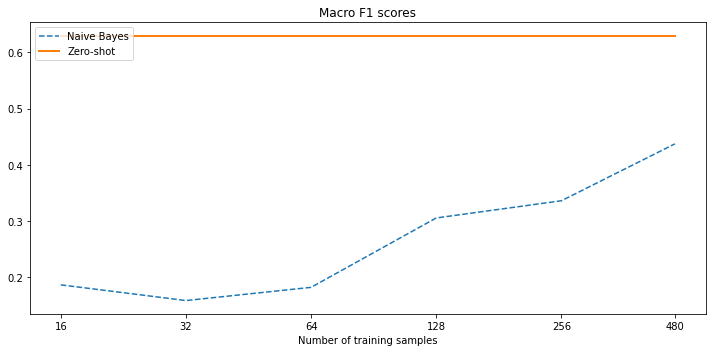

In [ ]:
plot_metrics(macro_scores, train_samples, "Zero-shot")

As can be seen, after translating the labels to the native language of the text and improving the semantic meaning of the labels, we were able to increase the accuracy of the model from 45% to 63%. If we were able to break down the labels even further (eg: instead of a generic news category, we break it down into, criminal, health, politics news etc) we would see an even greater increase in accuracy.

## Summary
Zero shot classification works considerably well in the absence of any training data - if you are able to overlook the long inference time which scales linearly with the number of labels. It is also important to choose semantically relevant labels (as specific as possible) and align the label language to the text language.

# Pretrained bert with classification head

One of the most standard ways of doing text classification with transformers is to take a pretrained bert model and attach a classification head on top.

Research (https://mccormickml.com/2019/07/22/BERT-fine-tuning/#:~:text=In%20fact%2C%20the%20authors%20recommend,a%20LSTM%20from%20scratch!) suggests that the optimal number of training epochs for fine-tuning should be between 2-4. However, based on initial testing, this is proven to be insufficient. The main difference here is that our training data is significantly smaller compared to the larger datasets used in said research. This results in there being insufficient updating of the weights across the model due to the lack of training steps. To account for this, we will train our model for 8 epochs as opposed to the recommended 2-4.


In [ ]:
from transformers import (AutoTokenizer, AutoConfig, AutoModelForSequenceClassification)
from transformers import Trainer, TrainingArguments
from datasets import load_metric
from sklearn.metrics import classification_report
from transformers import AdamW


model_ckpt = "bert-base-multilingual-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize(batch, max_len):
  return tokenizer(batch['text'], truncation=True, max_length=max_len)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/851k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.64M [00:00<?, ?B/s]

In [ ]:
training_args = TrainingArguments(
    output_dir="./",
    save_total_limit=2,
    num_train_epochs=8,
    learning_rate=3e-5,
    lr_scheduler_type="constant",
    per_device_train_batch_size=8,
    weight_decay=0.0,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="macro f1",
    load_best_model_at_end=True
)

def compute_metrics(pred):
  y_true = pred.label_ids
  y_pred = pred.predictions.argmax(-1)
  clf_dict = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
  return {"accuracy": clf_dict['accuracy'], "macro f1": clf_dict["macro avg"]["f1-score"]}

seq_lengths = [128, 256, 512]

for seq_len in seq_lengths:
  ds_enc = ds.map(lambda batch: tokenize(batch, seq_len), batched=True)
  ds_enc = ds_enc.remove_columns(['topic', 'text'])

  for train_slice in train_slices:
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=len(all_labels))
    trainer = Trainer(
        model=model,
        args=training_args,
        tokenizer=tokenizer,
        train_dataset=ds_enc['train'].select(train_slice),
        eval_dataset=ds_enc['valid'],
        compute_metrics=compute_metrics)
    trainer.train()

We experiment with different sequence lengths to see if it has any impact on the results of the trained model

Results (macro f1) for each train slice:   
Max seq length 128 - [0.039013, 0.042454, 0.182156, 0.231923, 0.631843, 0.722053]  
Max seq length 256 - [0.058197, 0.051165, 0.196605, 0.262047, 0.653356, 0.745273]  
Max seq length 512 - [0.056259, 0.089649, 0.117990, 0.396288, 0.646915, 0.688982]

Comparing across the results from the 3 sequence lengths, we can see that using a sequence length of 256 comes out slightly ahead. This is likely due to the nature of the data. A sequence length of 128 is not enough to capture the signal present in the article while this signal degrades when the whole article is encoded (probably due to more noise being added for lengthy articles)

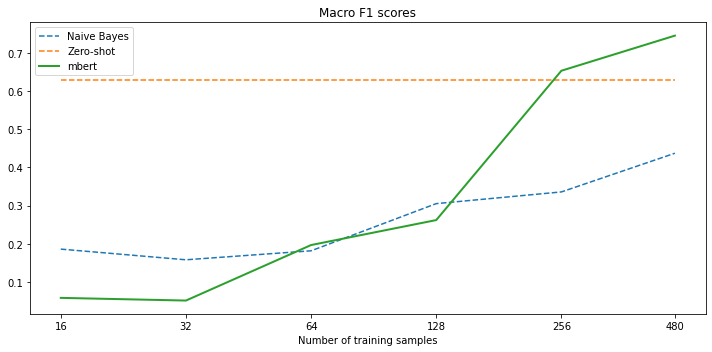

In [ ]:
macro_scores['mbert'] = [0.058197, 0.051165, 0.196605, 0.262047, 0.653356, 0.745273]
plot_metrics(macro_scores, train_samples, "mbert")

As expected, using BERT with a classification head results in the highest accuracy. However, this would only outperform zero-shot classification if you had at least 250 training examples.

# Finetune pre-trained BERT model on domain data

The most common method of improving BERT's accuracy is to fine-tune the pre-trained BERT model on your own domain data. 
Let's explore this method and see how much we can improve our model

In [ ]:
from transformers import DataCollatorForLanguageModeling, BertForMaskedLM

In [ ]:
def tokenize_mlm(batch):
  return tokenizer(batch["text"], truncation=True, max_length=128, return_special_tokens_mask=True)

ds_mlm = ds.map(tokenize_mlm, batched=True)
ds_mlm = ds_mlm.remove_columns(['topic', 'text', 'label_ids'])

In [ ]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer,
                                                mlm_probability=0.15)
training_args = TrainingArguments(
    output_dir='./models/mbert/',
    per_device_train_batch_size=8,
    evaluation_strategy='epoch',
    num_train_epochs=20,
    save_total_limit=2,
    logging_steps=15,
    report_to="none"
)

trainer = Trainer(
    model=BertForMaskedLM.from_pretrained('bert-base-multilingual-uncased'),
    args=training_args,
    train_dataset=ds_mlm['unsup'],
    eval_dataset=ds_mlm['train'],
    tokenizer=tokenizer,
    data_collator=data_collator
)

trainer.train()

trainer.model.save_pretrained(training_args.output_dir)

import pandas as pd
df_log = pd.DataFrame.from_records(trainer.state.log_history)
df_log.dropna(subset=['eval_loss'])['eval_loss'].plot(title='loss')
df_log.dropna(subset=['loss'])['loss'].plot();

In [ ]:
!cp ./models/mbert/ /content/drive/MyDrive/fine-tuning

We've fine-tuned the BERT model on our unsupervised data, let's see how much better the model can perform now.

In [ ]:
model_ckpt = "/content/drive/MyDrive/fine-tuning/"
config = AutoConfig.from_pretrained(model_ckpt)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=len(all_labels))

Some weights of the model checkpoint at /content/drive/MyDrive/fine-tuning/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /content/

In [ ]:
training_args = TrainingArguments(
    output_dir="./",
    num_train_epochs=8,
    save_total_limit=2,
    learning_rate=3e-5,
    lr_scheduler_type="constant",
    per_device_train_batch_size=8,
    weight_decay=0.0,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="macro f1",
    load_best_model_at_end=True
)

ds_enc = ds.map(lambda batch: tokenize(batch, 256), batched=True)
ds_enc = ds_enc.remove_columns(['topic', 'text'])

for train_slice in train_slices:
  trainer = Trainer(
      model=model,
      args=training_args,
      tokenizer=tokenizer,
      train_dataset=ds_enc['train'].select(train_slice),
      eval_dataset=ds_enc['valid'],
      compute_metrics=compute_metrics)
  trainer.train()

Results
[0.035569, 0.149032, 0.330740, 0.493679, 0.691404, 0.762574]

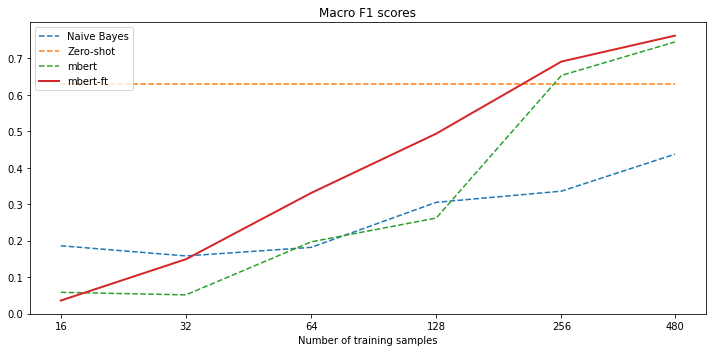

In [ ]:
macro_scores['mbert-ft'] = [0.035569, 0.149032, 0.330740, 0.493679, 0.691404, 0.762574]
plot_metrics(macro_scores, train_samples, "mbert-ft")

After fine-tuning the pre-trained BERT model, we are able to increase the accuracy by 2%.  
Fine-tuning on your own domain data is an easy way to increase the accuracy of the model.  
It does however take quite a long time to train.

# Data augmentation

The final method we will explore is data augmentation.  
One of the more common methods of data augmentation in NLP is the use of back-translation.  
In back-translation, you translate the original training data to a proxy language and then translate the translated training data from the proxy language back to the source language.  
For this example, we will make use of 2 proxy languages, english and spanish

In [ ]:
from tqdm import tqdm
tqdm.pandas()

ds.set_format(type="pandas")
train = ds['train'][:]

train_translated_en = train.copy(deep=True)
train_translated_es = train.copy(deep=True)

id_en_translator = OpusTranslator('id', 'en')
id_es_translator = OpusTranslator('id', 'es')

train_translated_en['text'] = train_translated_en['text'].progress_apply(lambda text: id_en_translator.back_translate(text, 'id'))
train_translated_es['text'] = train_translated_es['text'].progress_apply(lambda text: id_es_translator.back_translate(text, 'id'))


100%|██████████| 11.9k/11.9k [00:00<00:00, 3.31MB/s]
  0%|          | 0/480 [00:00<?, ?it/s]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Downloading:   0%|          | 0.00/782k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/777k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.20M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/278M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/777k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/782k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.20M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/278M [00:00<?, ?B/s]

  0%|          | 0/480 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/785k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/799k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/283M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/799k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/785k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/283M [00:00<?, ?B/s]

100%|██████████| 480/480 [36:23<00:00,  4.55s/it]


Let's look at the differences

In [ ]:
print(f"Original: {train.iloc[0]['text']}")
print(f"Backtranslated english: {train_translated_en.iloc[0]['text']}")
print(f"Backtranslated spanish: {train_translated_es.iloc[0]['text']}")

Original:   BEIJING,  - Miliarder teknologi China di balik Amazon versi Asia dilaporkan tidak terlihat di depan umum selama lebih dari 2 bulan setelah melakukan pelanggaran terhadap aturan Presiden Xi Jinping. Jack Ma, salah satu taipan China yang paling sukses dan blak-blakan, mengkritik regulator keuangan "pegadaian" negara komunis itu dan bank-bank milik negara dalam pidatonya di Shanghai pada Oktober. Baca juga: 30 Pejabat China Dihukum atas Kecelakaan Ledakan Kapal Tanker  Kritik pemerintah Melansir Daily Mail pada Minggu (4/1/2021), Ma menyerukan reformasi sistem yang "menahan inovasi bisnis" dan menyamakan peraturan perbankan global dengan "klub orang tua". Pidato Ma tersebut sontak membuat geram pemerintah China yang memandang kritik Ma sebagai serangan terhadap otoritas Partai Komunis, dan menyebabkan tindakan keras yang luar biasa terhadap kegiatan bisnis Ma. Baca juga: Profil Zhong Shanshan, Orang Terkaya Baru di Asia yang Geser Jack MaDapatkan informasi, inspirasi dan insig

In [ ]:
aug_train = pd.concat([train, train_translated_en, train_translated_es], ignore_index=True)
aug_train = aug_train.sample(frac=1)

ds_aug = DatasetDict({
    "train": Dataset.from_pandas(aug_train.reset_index(drop=True)),
    "valid": Dataset.from_pandas(valid.reset_index(drop=True)),
    "test": Dataset.from_pandas(test.reset_index(drop=True)),
    "unsup": Dataset.from_pandas(unsup.reset_index(drop=True))
})

ds_aug = ds_aug.map(prepare_labels)
pickle.dump(ds_aug, open('/content/drive/MyDrive/fine-tuning/aug_data.pkl', 'wb'))

  0%|          | 0/1440 [00:00<?, ?ex/s]

  0%|          | 0/481 [00:00<?, ?ex/s]

  0%|          | 0/481 [00:00<?, ?ex/s]

  0%|          | 0/2884 [00:00<?, ?ex/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

In [ ]:
ds_aug = pickle.load(open('/content/drive/MyDrive/fine-tuning/aug_data.pkl', 'rb'))
ds_aug = ds_aug.map(lambda batch: tokenize(batch, 256), batched=True)
ds_aug = ds_aug.remove_columns(['topic', 'text'])

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

Use the fine-tuned bert model

In [ ]:
model_ckpt = "/content/drive/MyDrive/fine-tuning/"
config = AutoConfig.from_pretrained(model_ckpt)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=len(all_labels))
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-uncased")

Some weights of the model checkpoint at /content/drive/MyDrive/fine-tuning/ were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /content/

In [ ]:
training_args = TrainingArguments(
    output_dir="./",
    num_train_epochs=8,
    save_total_limit=2,
    learning_rate=3e-5,
    lr_scheduler_type="constant",
    per_device_train_batch_size=8,
    weight_decay=0.0,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="macro f1",
    load_best_model_at_end=True
)

def compute_metrics(pred):
  y_true = pred.label_ids
  y_pred = pred.predictions.argmax(-1)
  clf_dict = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
  return {"accuracy": clf_dict['accuracy'], "macro f1": clf_dict["macro avg"]["f1-score"]}


trainer = Trainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    train_dataset=ds_aug['train'],
    eval_dataset=ds_aug['valid'],
    compute_metrics=compute_metrics)
trainer.train()

***** Running training *****
  Num examples = 1440
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1440


Epoch,Training Loss,Validation Loss,Accuracy,Macro f1
1,No log,0.553341,0.848233,0.665933
2,No log,0.527677,0.862786,0.720678
3,0.491600,0.768177,0.856549,0.736697
4,0.491600,0.860554,0.858628,0.742178
5,0.491600,0.809433,0.869023,0.742778
6,0.016700,1.012953,0.854470,0.717482
7,0.016700,0.899296,0.869023,0.744580
8,0.016700,0.917675,0.871102,0.749544


***** Running Evaluation *****
  Num examples = 481
  Batch size = 8
Saving model checkpoint to ./checkpoint-180
Configuration saved in ./checkpoint-180/config.json
Model weights saved in ./checkpoint-180/pytorch_model.bin
tokenizer config file saved in ./checkpoint-180/tokenizer_config.json
Special tokens file saved in ./checkpoint-180/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 481
  Batch size = 8
Saving model checkpoint to ./checkpoint-360
Configuration saved in ./checkpoint-360/config.json
Model weights saved in ./checkpoint-360/pytorch_model.bin
tokenizer config file saved in ./checkpoint-360/tokenizer_config.json
Special tokens file saved in ./checkpoint-360/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 481
  Batch size = 8
Saving model checkpoint to ./checkpoint-540
Configuration saved in ./checkpoint-540/config.json
Model weights saved in ./checkpoint-540/pytorch_model.bin
tokenizer config file saved in ./checkpoint-540/tok

NameError: ignored

After backtranslation, the model is able to achieve a macro f1 score of 74.9%, which is lower than the previous model. A possible explanation for this is because backtranslation depends heavily on the forward and backward translation accuracy. If the quality of the backtranslation are not good enough, they may end up confusing the model instead.

Next, we will explore a secondary method to perform data augmentation - Synonym replacements

In [ ]:
from transformers import set_seed
import nlpaug.augmenter.word as naw

In [ ]:
set_seed(3)
aug = naw.ContextualWordEmbsAug(model_path="bert-base-multilingual-uncased", device='cuda', action="substitute")
text = ds['train'][0]['text'][:300]
print(f"Original text: {text}")
print(f"Augmented text: {aug.augment(text)}")

Downloading:   0%|          | 0.00/641M [00:00<?, ?B/s]

Original text:   BEIJING,  - Miliarder teknologi China di balik Amazon versi Asia dilaporkan tidak terlihat di depan umum selama lebih dari 2 bulan setelah melakukan pelanggaran terhadap aturan Presiden Xi Jinping. Jack Ma, salah satu taipan China yang paling sukses dan blak-blakan, mengkritik regulator keuangan "


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Augmented text: twitter, - miliarder teknologi china men balik amazon versi lain dilaporkan tidak terlihat di depan umum jepang 16 dari 2 bulan setelah melakukan pelanggaran kontrak aturan presiden xi jinping. jack ma, bilang satu taipan china wanita paling sukses paling blak - blakan, mengkritik uang keuangan "


In [ ]:
def augment_text(batch, transformations_per_example=1):
  text_aug, label_ids = [], []
  for text, labels in zip(batch["text"], batch["label_ids"]):
    text_aug += [text]
    label_ids += [labels]
    for _ in range(transformations_per_example):
      text_aug += [aug.augment(text)]
      label_ids += [labels]
  return {"text": text_aug, "label_ids": label_ids}

In [ ]:
ds_enc = ds.map(lambda batch: tokenize(batch, 256), batched=True)
ds_enc = ds_enc.remove_columns(['topic', 'text'])

def compute_metrics(pred):
  y_true = pred.label_ids
  y_pred = pred.predictions.argmax(-1)
  clf_dict = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
  return {"accuracy": clf_dict['accuracy'], "macro f1": clf_dict["macro avg"]["f1-score"]}

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

Rerun training with augmented text

In [ ]:
training_args = TrainingArguments(
    output_dir="./",
    save_total_limit=2,
    num_train_epochs=8,
    learning_rate=3e-5,
    lr_scheduler_type="constant",
    per_device_train_batch_size=8,
    weight_decay=0.0,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="macro f1",
    load_best_model_at_end=True
)


for train_slice in train_slices:
  model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=len(all_labels))
  ds_aug = ds['train'].select(train_slice)
  ds_aug = ds_aug.map(augment_text, batched=True, remove_columns=ds_aug.column_names).shuffle(seed=42)
  ds_aug = ds_aug.map(lambda batch: tokenize(batch, 256), batched=True)
  ds_aug = ds_aug.remove_columns(['text'])
  trainer = Trainer(
      model=model,
      args=training_args,
      tokenizer=tokenizer,
      train_dataset=ds_aug,
      eval_dataset=ds_enc['valid'],
      compute_metrics=compute_metrics)
  trainer.train()

In [ ]:
!cp ./models/mbert/ /content/drive/MyDrive/fine-tuning/final-model/

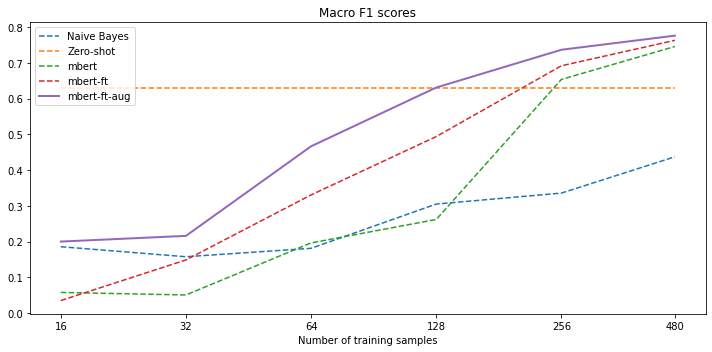

In [ ]:
macro_scores['mbert-ft-aug'] = [0.200348, 0.216261, 0.466521, 0.630695, 0.736178, 0.775633]
plot_metrics(macro_scores, train_samples, "mbert-ft-aug")

After fine-tuning the model on the unlabelled domain data as well as performing data augmentation prior to training, we were able to improve the model accuracy by 3.5%, which is quite a marked improvement. If we were able to fine tune the model on more unlabelled data, as well as create multiple augmentations on the training data, the increase in model accuracy would likely increase as well.  

Using our final model, let's check it's performance on our test set as well as perform some error analysis.

In [ ]:
pred = trainer.predict(ds_enc['test'])
metrics = compute_metrics(pred)
# metrics = {'accuracy': 0.8877, 'macro f1': 0.7765}

The model is able to achieve a score of 77.65% macro f1 on the test set. The validation and test results are relatively similar which shows that the model is not overfitting on the validation data.

In [ ]:
df_valid = pickle.load(open('/content/drive/MyDrive/fine-tuning/df_valid.pkl', 'rb'))

## Error analysis of model

Finally, we will investigate the model's prediction to see where it can be improved. We will do so by looking at validation samples which have the highest model loss. To get the model loss, we will define a new function which runs the validation data through the model and calculates the loss per sample

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    input_ids = torch.tensor(batch['input_ids'], device=device)
    attention_mask = torch.tensor(batch['attention_mask'], device=device)
    labels = torch.tensor(batch['label_ids'], device=device)
    
    with torch.no_grad():
        output = model(input_ids, attention_mask)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, labels, reduction="none")
    
    batch['predicted_label'] = pred_label.cpu().numpy()
    batch['loss'] = loss.cpu().numpy()
    return batch

In [ ]:
ds['valid'] = ds['valid'].map(lambda batch: tokenize(batch, 256), batched=True)
ds['valid'] = ds['valid'].map(forward_pass_with_label, batched=True, batch_size=1)

In [ ]:
ds.set_format('pandas')
cols = ['text', 'topic', 'predicted_label', 'loss']
df_valid = ds['valid'][:][cols]

In [ ]:
df_valid['predicted_label'] = df_valid['predicted_label'].apply(lambda x: reverse_label_map[x])

In [ ]:
highest_loss = df_valid.sort_values("loss", ascending=False).head(10)
highest_loss['text'] = highest_loss['text'].apply(lambda x: id_en_translator.forward(x))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Downloading:   0%|          | 0.00/782k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/777k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.20M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/278M [00:00<?, ?B/s]

In [ ]:
highest_loss['text'] = highest_loss['text'][:200]
highest_loss.style.set_properties(subset=['text'], **{'width': '300px'})

,text,topic,predicted_label,loss
200,"JACARTA, - State Court (PN) Depok will again hold a trial for alleged drug abuse against defendant Catherine Wilson on Wednesday (6/1/2020). According to the chairman's judge in the previous trial, the court's agenda this time is an expert witness hearing from Catherine Wilson's side. ""This afternoon we delay until January 6, 2021 Wednesday yes. The defendant's brother is willing to present an expert witness for the next trial,"" said the chairman of the trial at PN Depok, Tuesday (15/12/2020). Read also: Catherine Wilson's confession, Reason for Using Meth and Consumption When asked for information in the trial as defendant, Catherine admitted using meth to maintain stamina and maintain her weight. He's rationalized, he's consumed meth since the past two years because of the demands of work in entertainment to be attractive and energetic. Earlier, Chatrine Wilson was charged with section 114 and chapter 112 jo chapter 127 of the Act of Number 35 of 2009 on Narcotics. Get information, inspiration and insight in your email. This woman whom Keket said she was arrested by police at her residence at Jati Base, Cinere on July 17, 2020. During the arrest, the police confiscated two meth clips with a total of one gram.",HYPE,NEWS,10.654549
66,"DEPOK, - Defendant Catherine Wilson is at a loss because expert witnesses on her part are absent from the drug abuse hearing at the Depok State Court in West Java, Wednesday (1/1/2021). It was passed by the law of Catherine Wilson, Verna Wahono, when found after the trial. ""The losses remain, the name presents expert witnesses can benefit and affect Catherine's case,"" says Verna when found in PN Depok, Wednesday (6/1/2021). Read also: In Rutan, Catherine Wilson gnated at Verna's skin saying her side had sought expert witnesses to attend the trial. But it's a matter of not coming. As a result, the trial that the defendant's expert witness should examine is followed by the prosecution's reading of the prosecution's demands. ""It's also a coincidence that we want to cut back time, not long in this process, because it's been six months and it's been too long since the process,"" says Verna. Get the information, inspiration and insight in your email. The Attorney General (JPU) demanded Catherine Wilson be rehabilitated for eight months based on Article 127 of Rule 1 Act Number 35 of 2009 on Narcotics. Meanwhile, Catherine Wilson was charged with Article 114 of Section 112 of Section 1 jo chapter 127 of Act Number 35 of 2009 on Narcotics. Read also: Prosecutors Sue Artist Catherine Wilson 8 Months of Rehabilitation In that chapter, Catherine Wilson was accused of being a meth dealer with the threat of a maximum sentence of 20 years in prison. This woman whom Keket said she was arrested by police at her residence at Jati Base, Cinere on July 17, 2020. During the arrest, the police confiscated two meth clips with a total of one gram left over. Read also: No Master Witness, Catherine Wilson's Congregation Reads the Requirement Directly · Global Voices",HYPE,NEWS,10.621842
5,"- Indonesia again records the highest daily addition reported today, Thursday (7/1/2020). Speaker of the Covid-19 Task Force Wiku Adisasmito says, adding positive cases per January 7th is 9,321 cases. With that addition, then the total positive Covid-19 case in Indonesia to January 7, 2021 is 797,723 cases. Meanwhile, the number of active cases is 114,766, 659,437 people are cured, and 23.520 people are dead. ""It's good for me to pass on this data, the addition of daily cases is the highest since the beginning of the pandemic, reaching 9,000. Even this figure increased by nearly 500 in just one day,"" says Wiku, through a press conference, Thursday afternoon, on January 6, 2021, the total number of cases of the Covid-19 national 788,402 cases. Wiku says, this increase is the result of a long holiday. Get information, inspiration and insight in your email. The email release he spares people a

Most of the mislabelled examples stem from the labels being not very well-defined (hard to distinguish between what should be considered news vs what should be considered hype). We can remedy this by looking through some of the labels and adjusting them if required.

## Summary:

Having few or no labels is not such a huge problem in this day and age. By utilising transformers and fine-tuning them or augmenting the data, we have shown that we are able to achieve a respectably accurate model even with only a handful of labelled data.

## Future work:
Unsupervised Data Augmentation

Uncertainty-Aware Self-Training